In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
class Maximize(object):
    period = 30
    #np.random.seed(period)

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

In [3]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, gamma, aggregate_risk, corr=None, rho=None):
        self.n = n
        self.corr = corr
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)
        
        
    def MC_multi_data(self):
        self.brownian_ = np.random.multivariate_normal(np.zeros([self.corr.shape[0]]), self.corr, size=(self.n, self.period+2))
        self.market_ = self.brownian_[:, 0, 1:]
        self.hc_ = self.aggregate_risk*self.brownian_[:, :, :1].reshape(self.n, self.period+2)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
        
        
    def get_multiasset_ret(self, asset_data):
        self.asset_mu = asset_data.mean().value
        self.asset_std = asset_data.std().value
        
        self.R_t = np.exp(np.ones(self.market_.shape)*self.asset_mu + (0.5*(np.ones(self.market_.shape)*self.asset_std)**2) + (self.asset_std*self.market_))
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [4]:
def lc_asset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, rho=group_characherize_data["rho"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_asset_ret(market_mu=asset_data["risky"][0], market_sigma=asset_data["risky"][1], 
                            rf_mu=asset_data["rf"][0], rf_sigma=asset_data["rf"][1])
        opt_weights = model.fit()

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df


def data_plotting(lc_total_df):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ln1 = ax.plot(lc_total_df.index[::-1], lc_total_df.labor_income, color="b", label="labor_income")
    ax2 = ax.twinx()
    ln2 = ax2.plot(lc_total_df.index[::-1], lc_total_df.financial_wealth, color="r", linestyle="--", label="financial_wealth")

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

    plt.show()
    

def lc_weights_plot(lc_df):
    plt.figure(figsize=(10, 5))
    plt.fill_between(lc_df.index, lc_df["risky_asset"])
    plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
    plt.legend(["risky_asset", "risk_free"])
    plt.ylim(0, 100)
    plt.show()

In [5]:
asset_data = {"risky": [0.12, 0.35], "rf":[0.04, 0.03]}

## High_school edu levels
_______________

In [6]:
group_characherize_data = {"rho":0.633465, "aggregate_risk":np.sqrt(0.174855+0.005461), 
                           "fixed_effect_coeff":[7.5072-0.7417+0.3198+0.059*2], "age_coeff_list":[0.0124, 0.0064, -0.0009], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.5072-0.7417+0.3198+0.059*2 + (25 * 0.0124 + ((25**2 /10) *0.0064) + ((25**3/100) * -0.0009)))}

In [7]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [8]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2375.0,2595.0,2664.0,2752.0,2834.0,2889.0,2984.0,3066.0,3148.0,3223.0,...,4361.0,4408.0,4446.0,4444.0,4486.0,4496.0,4530.0,4509.0,4497.0,4508.0
financial_wealth,1000.0,2265.0,3900.0,6031.0,8785.0,12259.0,16759.0,22524.0,29945.0,39353.0,...,669860.0,767337.0,880843.0,1007054.0,1152491.0,1317926.0,1507393.0,1720899.0,1961549.0,2250383.0


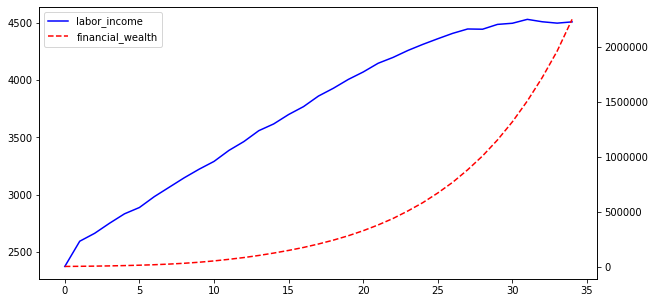

In [9]:
data_plotting(lc_data)

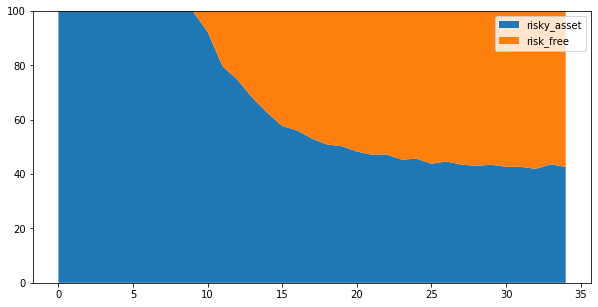

In [10]:
lc_weights_plot(lc_weights)

## College edu levels
_______________

In [11]:
group_characherize_data = {"rho":0.334903, "aggregate_risk":np.sqrt(0.145682+0.010166), 
                           "fixed_effect_coeff":[7.8016-2.3326+0.2550+0.0537*2], "age_coeff_list":[0.1232, -0.0193, 0.0011], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8016-2.3326+0.2550+0.0537*2 + (25 * 0.1232 + ((25**2 /10) * -0.0193) + ((25**3/100) * 0.0011)))}

In [12]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [13]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2636.0,2845.0,2977.0,3126.0,3267.0,3377.0,3527.0,3659.0,3787.0,3908.0,...,5473.0,5555.0,5624.0,5657.0,5729.0,5800.0,5888.0,5930.0,5978.0,6065.0
financial_wealth,1000.0,2361.0,4141.0,6482.0,9526.0,13386.0,18403.0,24845.0,33151.0,43697.0,...,745413.0,853188.0,978607.0,1118017.0,1278524.0,1460942.0,1669747.0,1904867.0,2169679.0,2487436.0


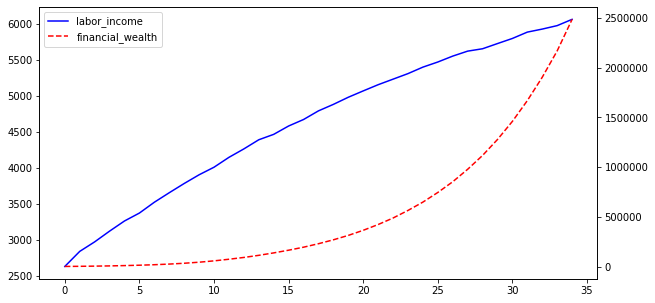

In [14]:
data_plotting(lc_data)

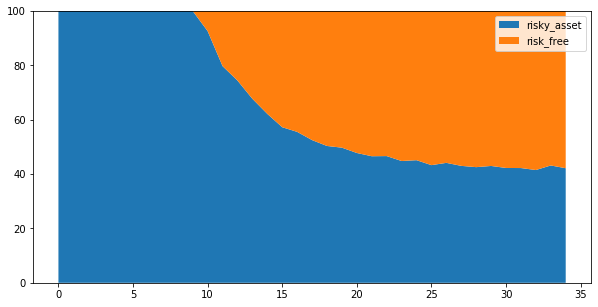

In [15]:
lc_weights_plot(lc_weights)

## University edu levels
_______________

In [16]:
group_characherize_data = {"rho":-0.010961, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [17]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [18]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3195.0,3358.0,3541.0,3719.0,3866.0,4054.0,4225.0,4390.0,4550.0,...,6212.0,6249.0,6250.0,6216.0,6191.0,6177.0,6154.0,6091.0,6008.0,5950.0
financial_wealth,1000.0,2494.0,4457.0,7044.0,10417.0,14705.0,20284.0,27458.0,36716.0,48480.0,...,854210.0,977894.0,1121739.0,1281653.0,1465794.0,1675075.0,1914478.0,2184127.0,2487930.0,2852432.0


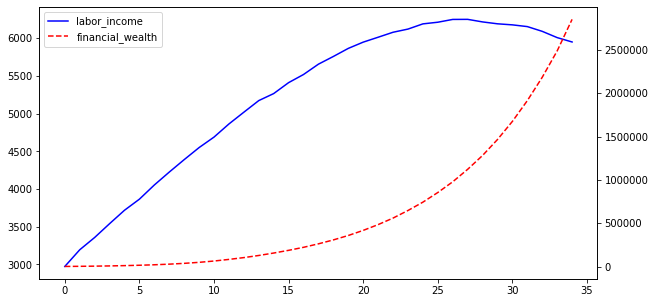

In [19]:
data_plotting(lc_data)

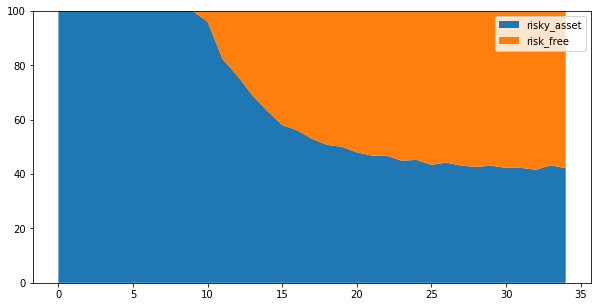

In [20]:
lc_weights_plot(lc_weights)

In [39]:
model = Maximize_Calibraton(n=10, rho=0.2, gamma=4, aggregate_risk=0.15)
model.MC_data()
model.get_asset_ret(0.12, 0.2, 0.4, 0.001)

In [40]:
model.R_t

array([[1.07096755, 1.49187626],
       [0.77480335, 1.49290097],
       [1.59422412, 1.49321093],
       [0.72498254, 1.48953423],
       [0.97469613, 1.49398335],
       [0.88440497, 1.49376791],
       [1.05534093, 1.48792601],
       [1.67273607, 1.49333381],
       [1.59152459, 1.49012975],
       [0.8722529 , 1.49372518]])

In [38]:
model.hc_.shape

(10, 32)

In [21]:
np.exp(0.12+(0.5*(0.35**2))+0.35*0)#+market_sigma*self.market_[:, 0]

1.1987148205416183

In [22]:
0.014*0.24*0.3

0.001008

In [23]:
np.exp(np.random.multivariate_normal([0.17, 0.04], [[0.06, 0.001],[0.001, 0.0002]], size=(3, 10)))

array([[[0.89278428, 1.02239294],
        [1.26444596, 1.04784919],
        [1.0296181 , 1.05487376],
        [1.12006758, 1.05039608],
        [1.76951794, 1.03290866],
        [1.19764837, 1.04817587],
        [1.67553884, 1.02719751],
        [1.33234848, 1.0497547 ],
        [1.21646137, 1.05375991],
        [1.64676912, 1.03633827]],

       [[1.11269784, 1.05411467],
        [1.23773324, 1.0523398 ],
        [1.3203477 , 1.03576106],
        [0.75955554, 1.04281659],
        [1.57594803, 1.05791199],
        [1.38719469, 1.02670741],
        [0.88513364, 1.03982431],
        [1.16453819, 1.00310161],
        [1.32053577, 1.06278236],
        [1.22330676, 1.04227674]],

       [[1.23827629, 1.06326791],
        [1.10161503, 1.04492761],
        [1.34855087, 1.02062875],
        [1.34826385, 1.055755  ],
        [1.18456649, 1.03096976],
        [1.41819665, 1.0381511 ],
        [1.08190815, 1.04521642],
        [1.87397429, 1.04518657],
        [1.66036742, 1.05559133],
        [1

In [24]:
np.random.seed(1)
b = np.random.multivariate_normal([0, 0], [[1, 0.3],[0.3, 1]], size=(3, 10))
b

array([[[-0.94766912, -1.67150907],
        [ 1.06060248, -0.20895112],
        [ 0.66389472, -2.05932259],
        [-0.95637614, -1.85704829],
        [-0.10968804, -0.40474705],
        [ 0.04000658, -2.39758478],
        [ 0.48715068,  0.03273144],
        [-0.2633697 , -1.5647786 ],
        [ 0.65836411, -0.38033198],
        [-0.37883194,  0.31076432]],

       [[ 0.21011987,  1.56457523],
        [-1.02416534, -0.42960602],
        [-0.32179443, -1.13079214],
        [ 0.65268593, -0.4545314 ],
        [-0.09778425,  0.5297408 ],
        [ 0.79235728,  0.32291217],
        [ 1.05404674,  0.05398594],
        [ 0.54866841,  0.53368345],
        [ 0.7621222 ,  1.0394866 ],
        [-1.77717454, -0.89917605]],

       [[ 0.67979114, -0.37046561],
        [-0.39889137,  1.60364792],
        [ 0.33588919, -0.41781423],
        [-1.39644868,  1.08860671],
        [-0.46201753,  0.26826704],
        [-0.03361123, -0.45039887],
        [ 1.12780156,  0.71445368],
        [-0.17863505,  0

In [25]:
b[:, 0, :] 

array([[-0.94766912, -1.67150907],
       [ 0.21011987,  1.56457523],
       [ 0.67979114, -0.37046561]])

In [26]:
b_w = np.ones([2])
b_w.shape

(2,)

In [27]:
b[:, 0, :] @ b_w

array([-2.6191782 ,  1.7746951 ,  0.30932553])

In [28]:
b.shape

(3, 10, 2)

In [29]:
np.exp(0.12+(0.5*(0.35**2))+0.35*0)+0.35*b[:, 0, :][:, 0]

array([0.86703063, 1.27225677, 1.43664172])

In [30]:
b[:, 0, :][:, 0]

array([-0.94766912,  0.21011987,  0.67979114])

In [31]:
np.hstack([np.ones([3, 10, 1]) * 0.17 + (0.5*(0.24**2)), np.ones([3, 10, 1]) * 0.04 + (0.5*(0.014**2))]).reshape(3, 2, 10)

array([[[0.1988  , 0.1988  , 0.1988  , 0.1988  , 0.1988  , 0.1988  ,
         0.1988  , 0.1988  , 0.1988  , 0.1988  ],
        [0.040098, 0.040098, 0.040098, 0.040098, 0.040098, 0.040098,
         0.040098, 0.040098, 0.040098, 0.040098]],

       [[0.1988  , 0.1988  , 0.1988  , 0.1988  , 0.1988  , 0.1988  ,
         0.1988  , 0.1988  , 0.1988  , 0.1988  ],
        [0.040098, 0.040098, 0.040098, 0.040098, 0.040098, 0.040098,
         0.040098, 0.040098, 0.040098, 0.040098]],

       [[0.1988  , 0.1988  , 0.1988  , 0.1988  , 0.1988  , 0.1988  ,
         0.1988  , 0.1988  , 0.1988  , 0.1988  ],
        [0.040098, 0.040098, 0.040098, 0.040098, 0.040098, 0.040098,
         0.040098, 0.040098, 0.040098, 0.040098]]])